# Dask through Jupyter Notebooks

This notebook runs a simple study on SUEP data using Dask, creating an output coffea file that can be analyzed in Dask_analysis.ipynb.

In [32]:
import os
import sys
import json
import time
import random
import numpy as np
import coffea
coffea.deprecations_as_errors = False #Get rid of warning for now
from coffea import hist, processor
from hist import Hist
import matplotlib

from dask_jobqueue import SLURMCluster
from distributed import Client
from dask.distributed import performance_report

We set up a coffea ABC Processor to analyze the ROOT files.

In [22]:
import awkward as ak
import vector
vector.register_awkward()

class Simple_Process(processor.ProcessorABC):
    def __init__(self, isMC: int, era: int, sample: str) -> None:
        self.gensumweight = 1.0
        self.era = era
        self.isMC = isMC
        self.sample = sample

        self._accumulator = processor.dict_accumulator(
            {
                "ht_gen": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("ht_gen", r"$H_T$ [GeV]", 100,0,2500),
                ),
                "ht_reco": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("ht_reco", r"$H_T$ [GeV]", 100,0,2500),
                ),
                "ht_reco_triggered": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("ht_reco_triggered", r"$H_T$ [GeV]", 100,0,2500),
                ),
                "gentracks": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("gentracks", r"$N_{tracks}$", 150, 0, 150),
                ),
                "nmuons": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("nmuons", r"$N_{muons}$", 30, 0, 30),
                ),
                "muon_pt": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("muon_pt", r"$Muon p_{T}$ [GeV]", 10, 0, 200),
                ),
                "muon_pt_triggered": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("muon_pt_triggered", r"$Muon p_{T}$ [GeV]", 10, 0, 200),
                ),
                "MET": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("MET", r"$p_{T}^{miss}$ [GeV]", 50, 0, 200),
                ),
                "sumw": processor.defaultdict_accumulator(float),
            }
        )
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator
        dataset = events.metadata['dataset']

        if self.isMC: self.gensumweight = ak.sum(events.genWeight)
        
        output["sumw"][dataset] += ak.sum(events.genWeight)
        
        # gen particles
        genparticles = ak.zip({
            "pt": events.GenPart.pt,
            "eta": events.GenPart.eta,
            "phi": events.GenPart.phi,
            "mass": events.GenPart.mass,
            "pdgId": events.GenPart.pdgId
        }, with_name="Momentum4D")
        cut = (events.GenPart.status == 1) & \
              (genparticles.pt > 0.7) & \
              (abs(genparticles.eta) < 2.5)
        genparticles = genparticles[cut]
        genmuons = genparticles[abs(genparticles.pdgId)==13]
    
        # gen jets
        jets = ak.zip({
            "pt": events.GenJet.pt,
            "eta": events.GenJet.eta,
            "phi": events.GenJet.phi,
            "mass": events.GenJet.mass,
        }, with_name="Momentum4D")
        jetCut = (jets.pt > 30) & (abs(jets.eta)<4.7)
        jets = jets[jetCut]
        
        muons = ak.zip({
            "pt": events.Muon.pt,
            "eta": events.Muon.eta,
            "phi": events.Muon.phi,
            "mass": events.Muon.mass,
            "mediumId": events.Muon.mediumId
        }, with_name="Momentum4D") 
        muon_triggered = muons[events.HLT.IsoMu24 == 1]
        muon_cut = (events.Muon.pt > 10) & \
            (abs(events.Muon.eta) <= 2.4) & \
            (events.Muon.mediumId == 1) 
        muons = muons[muon_cut]
        muon_triggered_cut = (muon_triggered.pt > 10) & \
            (abs(muon_triggered.eta) <= 2.4) & \
            (muon_triggered.mediumId == 1) 
        muon_triggered = muon_triggered[muon_triggered_cut]
        
        Ak4Jets = ak.zip({
            "pt": events.Jet.pt,
            "eta": events.Jet.eta,
            "phi": events.Jet.phi,
            "mass": events.Jet.mass,
        }, with_name="Momentum4D")
        Jets_triggered = Ak4Jets[events.HLT.PFHT1050 == 1]
        Ak4JetCut = (Ak4Jets.pt > 30) & (abs(Ak4Jets.eta)<4.7)
        Ak4Jets = Ak4Jets[Ak4JetCut]
        Jets_triggeredCut = (Jets_triggered.pt > 30) & (abs(Jets_triggered.eta)<4.7)
        Jets_triggered = Jets_triggered[Jets_triggeredCut]
                
        # fill out hists
        output['ht_gen'].fill(ht_gen=ak.sum(jets.pt,axis=-1), dataset=dataset)
        output['ht_reco'].fill(ht_reco=ak.sum(Ak4Jets.pt,axis=-1), dataset=dataset)
        jet_trig = ak.to_numpy(ak.sum(Jets_triggered.pt,axis=-1),allow_missing=True)
        output['ht_reco_triggered'].fill(ht_reco_triggered=jet_trig, dataset=dataset)
        output['gentracks'].fill(gentracks=ak.num(genparticles, axis=-1), dataset=dataset)
        
        output['nmuons'].fill(nmuons=ak.num(muons, axis=-1), dataset=dataset)
        muons = muons[ak.num(muons, axis=-1)>0]
        output['muon_pt'].fill(muon_pt=ak.max(muons.pt, axis=-1), dataset=dataset)
        muon_trig = ak.to_numpy(ak.max(muon_triggered.pt, axis=-1),allow_missing=True)
        output['muon_pt_triggered'].fill(muon_pt_triggered=muon_trig, dataset=dataset)
        output['MET'].fill(MET=events.MET.pt, dataset=dataset)
                
        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [3]:
def check_port(port):
    import socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    try:
        sock.bind(("0.0.0.0", port))
        available = True
    except:
        available = False
    sock.close()
    return available

The following section defines additional parts of the slurm Dask job. Here we source the bashrc to prepare Conda. We also pass in the x509 proxy. In order to share the proxy across the SubMIT machines you should move your proxy to your HOME directory.

In [4]:
slurm_env = [
     'export XRD_RUNFORKHANDLER=1',
     'export XRD_STREAMTIMEOUT=10',
     f'source {os.environ["HOME"]}/.bashrc',
     f'conda activate dask',
     f'export X509_USER_PROXY={os.environ["HOME"]}/x509up_u206148'
]

extra_args=[
     "--output=dask_job_output_%j.out",
     "--error=dask_job_output_%j.err",
     "--partition=submit",
     "--clusters=submit",
]

In [5]:
n_port       = 6820
w_port       = 9765
cores        = 1
processes    = 1
memory       = "5 GB"
chunksize    = 100000
maxchunks    = None

The following sets up the processor and json file. If you want to change files you can simply modify the json file

In [6]:
# load samples
file = "../filelist/list_2018_MC_A01.txt"
samples = []
with open(file, 'r') as stream:
    for sample in stream.read().split('\n'):
        if '#' in sample: continue
        if len(sample.split('/')) <= 1: continue
        sample_name = sample.split("/")[-1]
        samples.append(sample_name)

In [7]:
# load file names
samples_dict = {}
for sample_name in samples:
    
    # ignores SUEP files since we want to use another one
    if 'SUEP' in sample_name: continue
    
    input_list = "/home/tier3/cmsprod/catalog/t2mit/nanosu/A01/{}/RawFiles.00".format(sample_name)
    
    files = []
    Raw_list = open(input_list, "r")
    for i in Raw_list:
        file = i.split(" ")[0]
        files.append(file)
    
    samples_dict[sample_name] = files

In [8]:
# load SUEP files
suepDir = "/work/submit/freerc/Carlos/"
suep_dict = {}
for sample in os.listdir(suepDir):
    #if "M125" not in sample: continue
    if "ggHpythia_generic" not in sample: continue
    mass = sample.split("_")[2]
    suep_dict.update({mass: [suepDir + sample + "/GEN/total.root"]})

In [9]:
# combine QCD, data, and SUEP files
process_dict = {}
for key in list(samples_dict.keys()):
    process_dict.update({key:samples_dict[key][:5]})#Only take 10 files for now.
#process_dict = process_dict | suep_dict

#process_dict

In [10]:
# cross section
xsections = {}
for sample in list(process_dict.keys()):
    xsection = 1.0
    if 'QCD' in sample:
        with open('../data/xsections_{}.json'.format('2018')) as file:
            MC_xsecs = json.load(file)
            try:
                xsection *= MC_xsecs[sample]["xsec"]
                xsection *= MC_xsecs[sample]["kr"]
                xsection *= MC_xsecs[sample]["br"]
            except:
                print("WARNING: I did not find the xsection for that MC sample. Check the dataset name and the relevant yaml file")
                print(sample)
        xsections.update({sample:xsection})
    else:
        xsections.update({sample:xsection})

The next section forms the Slurm Cluster. You can set up various parameters of the cluster here.

In [11]:
while not check_port(n_port):
    time.sleep(5)

import socket
cluster = SLURMCluster(
        queue='all',
        project="SUEP_Slurm",
        cores=cores,
        processes=processes,
        memory=memory,
        #retries=10,
        walltime='00:30:00',
        scheduler_options={
              'port': n_port,
              'dashboard_address': 8000,
              'host': socket.gethostname()
        },
        job_extra=extra_args,
        env_extra=slurm_env,
)

/work/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8000 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 15073 instead
  warnings.warn(


In [12]:
cluster.adapt(minimum=1, maximum=250)
client = Client(cluster)
print(client)

<Client: 'tcp://18.12.2.18:6820' processes=0 threads=0, memory=0 B>


## Running the processor
Now we will run the code with a performance report. This will analyze all of the input ROOT files and will store the histograms in output. Then we can analyze the output and make plots.

In [23]:
processor_instance = Simple_Process(isMC=1, era='2018', sample='test')
with performance_report(filename="dask-report.html"):
    output = processor.run_uproot_job(process_dict,
             treename='Events',
             processor_instance=processor_instance,
             executor=processor.dask_executor,
             executor_args={
                           'client': client,
                           'skipbadfiles': True,
                           'schema': processor.NanoAODSchema,
                           'xrootdtimeout': 10,
                           'retries': 3,
                           },
             chunksize=100000,
             maxchunks=maxchunks)

In [24]:
client.cancel(cluster)

# just in case this isn't working as expected
#coffea.util.save(output, "unscaled_output.coffea")

# calculate normalization
scales = {} 
for dataset in output["sumw"]:
    xsec = xsections[dataset]
    scale = xsec / output["sumw"][dataset]
    scales.update({dataset: scale})

# apply normalization to all histograms
for key in list(output.keys()):
    if key.lower() == 'sumw': continue
    print(key)
    output[key].scale(scales, axis='dataset')

coffea.util.save(output, "output.coffea")

ht_gen
ht_reco
ht_reco_triggered
gentracks
nmuons
muon_pt
muon_pt_triggered
MET


### We can make some plots here too! But most of the analysis is in Dask_analysis.ipynb

/work/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/work/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
/tmp/ipykernel_3596721/4124763327.py:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  _ = ax.set_ylim(0, 10000000000)


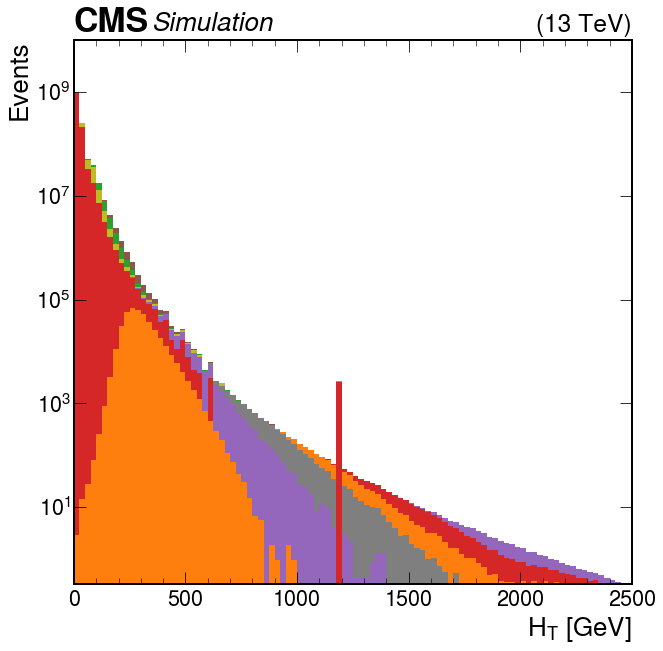

In [25]:
from coffea.hist import plot
import matplotlib.pyplot as plt
import mplhep as hep

fig = plt.figure()
ax = fig.subplots()

#hep.cms.label(data=False, year='2018')
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)

_ = ax.set_yscale('log')
plot.plot1d(output['ht_reco']["QCD_Pt*"], ax=ax, clear=False, stack=True)
_ = ax.set_xlim(0,2500)
_ = ax.set_ylim(0, 10000000000)
ax.get_legend().remove()

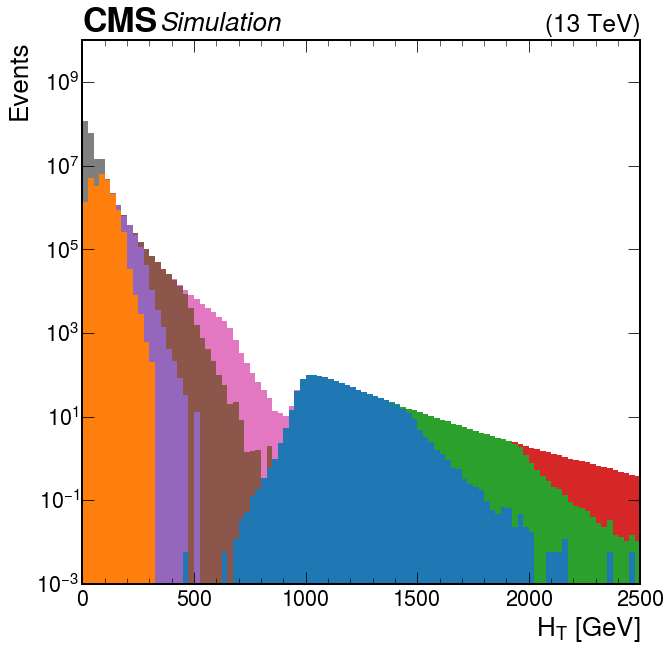

In [26]:
fig = plt.figure()
ax = fig.subplots()

hep.style.use("ROOT")
hep.cms.label(data=False)

_ = ax.set_yscale('log')
plot.plot1d(output['ht_gen']["QCD_HT*"], ax=ax, clear=False, stack=True)

_ = ax.set_ylim(0.001, 10000000000)
ax.get_legend().remove()

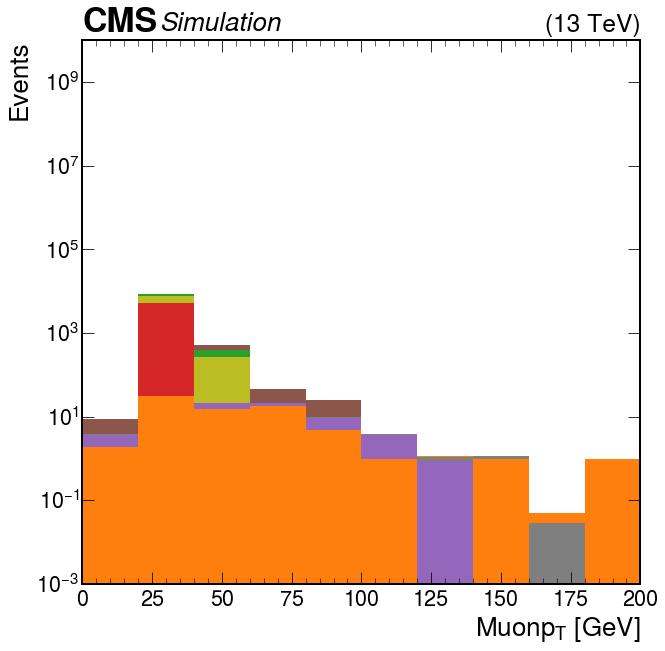

In [27]:
fig = plt.figure()
ax = fig.subplots()

hep.style.use("ROOT")
hep.cms.label(data=False)

_ = ax.set_yscale('log')
plot.plot1d(output['muon_pt_triggered']["QCD_Pt*"], ax=ax, clear=False, stack=True)
_ = ax.set_ylim(0.001, 10000000000)
ax.get_legend().remove()

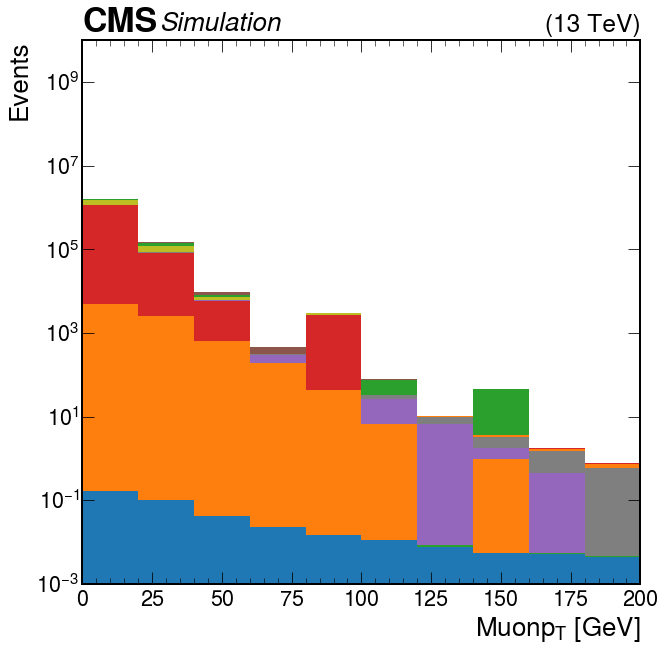

In [28]:
fig = plt.figure()
ax = fig.subplots()

hep.style.use("ROOT")
hep.cms.label(data=False)

_ = ax.set_yscale('log')
plot.plot1d(output['muon_pt']["QCD_Pt*"], ax=ax, clear=False, stack=True)
_ = ax.set_ylim(0.001, 10000000000)
ax.get_legend().remove()

In [29]:
val_trig = 0
val = 0
i = 0
for sample in output['ht_reco_triggered'].project('dataset').values():
    if 'QCD_Pt' not in sample[0]: continue
    bh_trig = output['ht_reco_triggered'][sample[0]].to_boost()
    bh = output['ht_reco'][sample[0]].to_boost()
    if i == 0:
        bins_use = bh_trig.axes.edges[1][0]
        val_trig = bh_trig.values()[0]
        val= bh.values()[0]
    else:
        val_trig += bh_trig.values()[0]
        val += bh.values()[0]
    i += 1
print(val_trig/val)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.23519259e-07 7.29436965e-08 3.54855014e-06
 1.00332713e-05 2.00332881e-05 9.85830223e-06 3.00194483e-05
 9.94440872e-05 1.21515116e-04 7.92641193e-05 1.26656536e-04
 4.84598986e-04 4.09977323e-04 5.25951858e-04 7.21056818e-04
 1.14127848e-03 1.97265065e-03 3.53524612e-03 7.44622809e-03
 2.08741017e-02 6.16206129e-02 1.53089822e-01 3.22513412e-01
 5.07067135e-01 6.46584337e-01 7.70833314e-01 1.88869888e-02
 8.94270773e-01 9.03940196e-01 9.28705807e-01 9.51032446e-01
 9.58848670e-01 9.56904947e-01 9.61113989e-01 9.73894332e-01
 9.73316758e-01 9.88211242e-01 9.90521318e-01 9.89404714e-01
 9.97074953e-01 9.95396606e-01 9.94834191e-01 9.97529344e-01
 9.97950680e-01 9.990884

In [30]:
binc = np.array([ 0.5*(bins_use[i]+bins_use[i+1])for i in range(bins_use.shape[0]-1)])
xerr = np.diff(bins_use)*0.5

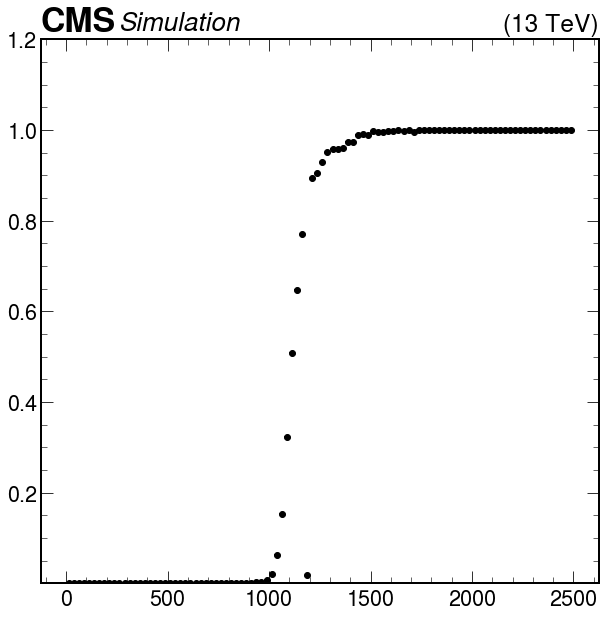

In [31]:
fig = plt.figure()
ax = fig.subplots()

#hep.cms.label(data=False, year='2018')
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)
binc = np.array([ 0.5*(bins_use[i]+bins_use[i+1])for i in range(bins_use.shape[0]-1)])

x = val_trig/val
x = np.nan_to_num(x)
plt.errorbar(binc,x, xerr=xerr,color="black", fmt='o')
_ = ax.set_ylim(0.001, 1.2)